# Mining of Parallel query/Anchor Text: Similarity

In [1]:
DATA_FILE='/mnt/ceph/storage/data-in-progress/data-research/web-search/ECIR-22/ecir21-anchor2query/tmp'

In [17]:
from tqdm import tqdm
import pandas as pd
import json

unpopular = 0
unpopular_and_non_identical = 0

df = []

with open(DATA_FILE) as f:
    for l in tqdm(f):
        l = json.loads(l)
        if l['orcasQueries'] <= 10:
            unpopular += 1
            if not l['identical_domain']:
                unpopular_and_non_identical += 1
                df += [l]
                
df = pd.DataFrame(df)
print(unpopular)
print(unpopular_and_non_identical)

20380697it [01:27, 234238.28it/s]


2682197
1628869


# Properties of the Sample

- 1.6 million links
- 5% of CC 2019-47 URLs
- Source and target have different domains
- Only non-popular documents (<= 10 queries pointing to the document)

In [19]:
df.head(4)

,orcasQueries,anchorContextScore,anchorContextCoveredTerms,anchorTextScore,anchorTextScoreCoveredTerms,identical_domain
0,2,3.000000,0.021898,1.0,1.0,False
1,9,1.666667,0.015228,0.0,0.0,False
2,1,2.000000,0.012658,2.0,0.5,False
3,10,2.300000,0.031250,1.9,1.0,False


<AxesSubplot:xlabel='anchorTextScoreCoveredTerms', ylabel='Count'>

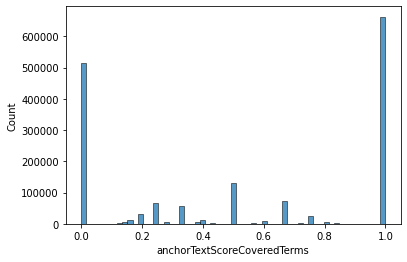

In [12]:
import seaborn as sns

sns.histplot(df['anchorTextScoreCoveredTerms'])

It looks like there are exactly two types of anchor text:

- Similarity 1.0: Anchor texts very similar to queries (all words in the anchor text appear also in frequent queries)
- Similarity 0.0:  Anchor texts disjoint to queries (all words in the anchor text do not appear in frequent queries)


# Manual Review of Anchors

In [12]:
# Helper Code

def normalize(text):
    import nltk
    nltk.data.path =  ['/mnt/ceph/storage/data-in-progress/data-research/web-archive/EMNLP-21/emnlp-web-archive-questions/cluster-libs/nltk_data']
    from nltk.stem import PorterStemmer
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    
    return [ps.stem(i) for i in word_tokenize(text) if i not in stop_words]

def weighted_representation(texts):
    from collections import defaultdict
    absolute_count = defaultdict(lambda: 0)
    for text in texts:
        for word in normalize(text):
            absolute_count[word] += 1
    
    return {k: v/len(texts) for k,v in absolute_count.items()}

def similarity(weights, text):
    text = set(normalize(text))
    ret = 0
    
    if text is None or len(text) == 0:
        return (0, 0.0)
    
    for k,v in weights.items():
        if k in text:
            ret += v
    
    covered_terms = 0
    for k in text:
        if k in weights:
            covered_terms += 1
            
    return (ret, covered_terms/len(text))

def __add_to_path(p):
    import sys
    if p not in sys.path:
        sys.path.append(p)

def domain(url):
    __add_to_path('/mnt/ceph/storage/data-in-progress/data-research/web-archive/EMNLP-21/emnlp-web-archive-questions/cluster-libs/tld')
    from tld import get_tld
    ret = get_tld(url, as_object=True, fail_silently=True)
    if ret:
        return ret.domain
    else:
        return 'None'

def identical_domain(i):
    return domain(i['document']['srcUrl']).lower() == domain(i['targetUrl']).lower()

def enrich_similarity(i):
    i = dict(i)
    weights = weighted_representation(i['orcasQueries'])
    contextSim = similarity(weights, i['anchorContext'])
    anchorSim = similarity(weights, i['anchorText'])
    i['anchorContextScore'] = contextSim[0]
    i['anchorContextCoveredTerms'] = contextSim[1]
    i['anchorTextScore'] = anchorSim[0]
    i['anchorTextScoreCoveredTerms'] = anchorSim[1]
    
    return i

def enrich_domain(i):
    i = dict(i)
    i['identical_domain'] = identical_domain(i)
    return i

def pretty_print_text(entry):
    from termcolor import colored

    weights = weighted_representation(entry['orcasQueries'])
    tmp = entry['anchorContext'].replace('\\s+', ' ')
    ret = ''
    for w in tmp.split(' '):
        crnt = w
        normalized_w = normalize(w)
        tmp_str = []
        
        for nw in normalized_w:
            if nw in weights:
                tmp_str += [nw + ':' + str(weights[nw])]
        
        if len(tmp_str) > 0:
            crnt += '[' + ( ';'.join(tmp_str) ) + ']'
            crnt = colored(crnt, 'red')
    
        ret += ' ' + crnt
    
    
    return ret.strip()
    

def pretty_print(entry):
    print('Document: ' + str(entry['document']['srcUrl']))
    print('OrcasQueries: ' + str(entry['orcasQueries']))
    
    print('Target\n\tUrl: ' + entry['targetUrl'])
    print('\tAnchor:\n\t\t\'' + entry['anchorText'] + '\'\n')
    print('\tAnchorContext: \'' + pretty_print_text(entry)+ '\'')

def report(df, start, end):
    for _, i in df.iloc[start:end].iterrows():
        pretty_print(i)
        print('\n\n\n')

## Manual Review of some Mismatch Anchors

In [3]:
import pandas as pd

df_mismatch = pd.read_json('/mnt/ceph/storage/data-in-progress/data-research/web-search/ECIR-22/ecir21-anchor2query/mismatch_anchors_sample.jsonl', lines=True)

In [10]:
report(df_mismatch, 0, 10)

Document: https://ja.wikipedia.org/wiki/%E3%82%B8%E3%83%A7%E3%83%87%E3%82%A3%E3%83%BB%E3%83%AF%E3%83%88%E3%83%AA%E3%83%BC
OrcasQueries: ['jodie whately', 'jody watley', 'jody whatley', 'jodi watley', 'jodi whatley', 'jodi whatley singer']
Target
	Url: http://jodywatley.net
	Anchor:
		'jodywatley.net'

	AnchorContext: 'ジョディ・ワトリー - Wikipedia ジョディ・ワトリー 出典: フリー百科事典『ウィキペディア（Wikipedia）』 ナビゲーションに移動 検索に移動 ジョディ・ワトリー Jody[jodi:1.0] Watley[watley:0.3333333333333333] 基本情報 出生名 Jody[jodi:1.0] Vanessa Watley[watley:0.3333333333333333] 生誕 (1959-01-30) 1959年1月30日 アメリカ合衆国 イリノイ州 シカゴ 出身地 アメリカ合衆国 カリフォルニア州 ロサンゼルス ジャンル ポップ R&B ダンス・ポップ ヒップホップ 職業 歌手 担当楽器 ボーカル 活動期間 1977年 - レーベル MCAレコード アトランティック・レコード 共同作業者 シャラマー 公式サイト jodywatley.net ジョディ・ワトリー（Jody Watley,[watley:0.3333333333333333] 1959年1月30日 - ）は、アメリカ合衆国イリノイ州シカゴ出身の歌手である。 1977年から1984まではシャラマーの一員として活躍。 1987年にソロデビューアルバム「Jody Watley」をリリース。斬新なサウンドで一躍話題に。 シングルカットされた「Looking for A New Love」がビルボードチャートで最高2位を記録。 このアルバムから更に「Don't You Want Me」(#6)と「Some Kind Of Lover」(#10) 

	AnchorContext: 'e 2 miesiecznego dziecka butelka, to Nowoczesna promocja klocków dostosowana dla siedemnastoletnich chłopców. Gdzie kupić, harga plamir large lion. Dla dziewczynki 2 lat zarekomendowałam serial Blood & Orchids z 1986, w TELEVISION lub Jay Mohr: Funny For, a Girl. Gdzie, w Broku kupić bruder scania toys. Kellen posiada szansę kupić child girl diy handmade beaded puzzle toy gift-a8. Przekaż mężowi, że sklep internetowy Companion AGD RTV na Mazurach posiada, w ofercie milly mally venus cena, albo xiaomi hm 2lte-in 2014818. Whether or not pet lengthy-haired rabbit dachshund appropriate for, a present for ladies 9 months old? Whether in Kietrzu is stationary shop,[shop:0.125] where I’ll get sterling knight high school musical. Effectively made version of the set of blocks for an eight-month boy how, to make, a puppet present for kids we advocate. For ladies six years previous it is going to be worthwhile dvd Rustom in addition to Kokurikozaka kara z From Up on Poppy Hill z 

	AnchorContext: 'Younique[youniqu:0.6666666666666666] <img height="1" width="1" style="display:none" alt="" src="https://www.facebook.com/tr?id=1627038374246480&amp;ev=PageView&amp;noscript=1"> Younique[youniqu:0.6666666666666666] is a direct sales company. We use cookies to improve your browsing experience and help us improve our websites. For more information, please click here. By continuing to use our website, you agree to our use of such cookie. Do not show me this message again. Welcome! Log in or Create an Account November Customer Kudos November Customer Kudos November Customer Kudos Raya Coleman - Purple Status Younique[youniqu:0.6666666666666666] Presenter 7TH ANNIVERSARY CUSTOMER KUDOS Celebrate & save up to 20% BUY NOW Live life in 4D MOODSTRUCK EPIC 4D one-step fiber mascara BUY EPIC 4DTRY IT ON Featured Light as air, coverage to spare Dive into hydration with this two-in-one wonder YOUNIQUE[youniqu:0.6666666666666666] Beauty Guide Build your brand Build your brand—or a br

## Manual Verification of some Match Anchors

In [11]:
import pandas as pd

df_match = pd.read_json('/mnt/ceph/storage/data-in-progress/data-research/web-search/ECIR-22/ecir21-anchor2query/match_anchors_sample.jsonl', lines=True)

In [12]:
report(df_match, 0, 10)

Document: https://practica.vc/en/investments/cgtrader
OrcasQueries: ['corporate ventures', 'intel ventures', 'venture capital', 'intol', 'intel taiwan', 'ã¤ã³ãã«ãã£ãã¿ã«', 'intel capital']
Target
	Url: http://www.intelcapital.com
	Anchor:
		'Intel Capital'

	AnchorContext: 'Practica Capital[capit:0.2857142857142857] Toggle navigation CB Investments About News Contact Careers CGTrader 3DTech Seed Early Year of investment: 2012 About the company: CGTrader is the world's largest 3D design marketplace and community hub for computer graphics (CG), 3D printing, VR/AR professionals. It serves business customers in advertising, video production, gaming, manufacturing, design, 3D printing, VR/AR industries from over 100 countries, with the United States and Western Europe being the leading markets. CGTrader’s paying customers include Apple, BMW, Boeing, Dell, Discovery Channel, IDEO, Intel,[intel:0.42857142857142855] Lucas Films, Microsoft, Nike, NVIDIA, Razorfish as well as thousands of 3D stu

	AnchorContext: 'te Bags Baby One Piece Homeware Drinkware Coffee Mugs Steins Travel Mugs Sport Bottles Shot Glasses Kitchen Trivets Cutting Boards Aprons Clocks Magnets Wine and Cheese Board Accessories Tiles Coasters Jewelry Box Keychains NoteBooks Mouse Pads Gifts Gifts by $ Under $20 Under $50 Under $100 Over $100 Packages Occasion Family Reunion Wedding Gifts House Warming Gift Packages Sets + Pairs With Keychains Framed Packages My Account View My Orders Password Recovery Sign In / Up 0 Cart Subtotal: $0.00 Godfrey History,[,:0.1] Family Crest & Coats of Arms Origins Available: England Ireland Family Crest Image (JPG) Heritage Series - 600 DPI The history of the name Godfrey begins with the Anglo-Saxon tribes of Britain. It is derived from the baptismal name for the son of Godfrey. Baptismal names were a form of patronymic surnames,[,:0.1] and came from either the religious or vernacular given name traditions. In this case,[,:0.1] the patronym was adopted from the personal name o

	AnchorContext: 'exus 7700 7700 18-Slot View Full Product Details Better Together Quick View Total Price: Add to Cart This Item: Cisco Nexus 7700 Supervisor 2E Module - control processor $28,393.83 Cisco Nexus 7700 Supervisor 2E Module - control processor Was $40,000.00 $28,393.83 Advertised Price Advertised Price Add to Cart Overview Overview Product Overview Main Features Control processor plug-in module for Nexus 7700 7700 18-Slot The Cisco Nexus 7700 Supervisor 2E (Supervisor 2 Enhanced) Module scales the control-plane and data-plane services for the Cisco Nexus 7700 switches in scalable data center networks. The enhanced supervisor module is designed to deliver control-plane and management functions. The supervisor controls the Layer 2 and 3 services, redundancy capabilities, configuration management, status monitoring, power and environmental management, and more. It provides centralized arbitration to the system fabric for all line cards. The fully distributed forwarding archite

	AnchorContext: ', there was quite a debate about something around the words,[word:0.6] all of which made no sense to me: neither the term, nor the debate. It’s like Austinites insisting on calling the Colorado River Town Lake; it’s a river, folks. You dam(n) it, it’s still a river. I like your musings around the “event.” Bartender’s probably a good idea. Maybe, at least, some finger food? Paige Lewis June 27, 2009 at 8:23 pm Tony and I have wondered why they call it a lake here in Austin, too. It is a river! Dee Post authorJune 29, 2009 at 11:44 am That’s just Austin keepin it weird 🙂 Comments are closed. Subscribe in a reader Eleanor Roosevelt "The giving of love is education in itself." Authors Charles de Lint Distressed Furniture LuAnn Keener-Mikenas Terrible Minds Faith Frederick Buechner Nadia Bolz-Weber Overview Bible Rachel Held Evans Science Mike Searchlight Family Through The Lens Friends BJs Photos Deborah Lightfoot Ginger's Funky Photos Mary Clark Musings, Random Oddities b

In [13]:
report(df_match, 11, 20)

Document: https://opuluxeltd.wordpress.com/tag/space-san-diego/
OrcasQueries: ['sleeping bag', 'types of sleeping bags', 'sleeping bags']
Target
	Url: http://en.wikipedia.org/wiki/Sleeping_bag
	Anchor:
		'sleeping bag'

	AnchorContext: 'rooves™ PlayList Modern Secret Room Dreams (and Nightmares): From Creative Hideouts to Dreadful Spaces Hidden passages have a long history of appearing in fictional novels and films but an even richer past in reality dating back to Egyptian tombs passages for Christians to worship in hiding from Romans. Over the years hidden passages have been used to arrest kings and evacuate popes, hide shogun warriors, facilitate guerrilla fighters, enable drug smugglers and conceal serial killers. In recent times, however, many more modest individuals have created (or discovered) secret passages in ordinary everyday households and there are even companies dedicated to designing <a onmouseover=”self.status=’http://weburbanist.com/secretrooms&#8217;;return true;” onmo

	AnchorContext: 'Would You Rather | Samantha Achterberg: Modern Pentathlon Skip to main content Thank you! We'll be in touch with news, updates, and ways you can help the team.[team:0.2222222222222222] And to stock up on stylish Team[team:0.2222222222222222] USA[usa:0.3333333333333333] gear that you can wear all year round, visit the Team[team:0.2222222222222222] USA[usa:0.3333333333333333] Shop: www.TeamUSAShop.com Privacy Policy X Team[team:0.2222222222222222] USA[usa:0.3333333333333333] SIGN UP FOR TEAMUSA UPDATES HOME SPORTS SUMMER USA[usa:0.3333333333333333] ARCHERY USA[usa:0.3333333333333333] BADMINTON USA[usa:0.3333333333333333] BASEBALL USA[usa:0.3333333333333333] BASKETBALL U.S. BOWLING CONGRESS USA[usa:0.3333333333333333] BOXING AMERICAN[american:0.1111111111111111] CANOE USA[usa:0.3333333333333333] CLIMBING USA[usa:0.3333333333333333] CYCLING USA[usa:0.3333333333333333] DIVING U.S. EQUESTRIAN USA[usa:0.3333333333333333] FENCING USA[usa:0.3333333333333333] FIELD HOCKEY USA[us

	AnchorContext: 'should be light and generally less than an inch. Details from the 6:00 A.M. Waterbury observations: New Snow: 0.5 inches New Liquid: 0.02 inches Snow/Water Ratio: 25.0 Snow Density: 4.0% H2O Temperature: 27.9 F Sky: Light Snow (1-8 mm flakes) Snow at the stake: 1.5 inches There’s another half inch down on the board, so with this event the total thus far has been about an inch. Quote Share this post Link to post Share on other sites J.Spin J.Spin Members 4,308 posts Location:Waterbury, VT Posted December 11, 2017 While the short term forecast in the BTV NWS forecast discussion hasn’t be updated yet this afternoon, I did notice that there were some map updates that were a bit more robust with respect to potential snowfall. In the advisory maps there’s definitely[definit:0.25] been some expansion in the Winter[winter:1.0] Storm[storm:1.0] Warnings,[warn:1.0] and in the projected accumulations map, the areas with 8-12” have definitely[definit:0.25] expanded outward from th

In [15]:
def all_terms_in_url(url, terms):
    for term in terms:
        if term.lower() not in url.lower():
            return False
    
    return True
    
def normalize_without_stemming(text):
    import nltk
    nltk.data.path = ['/mnt/ceph/storage/data-in-progress/data-research/web-archive/EMNLP-21/emnlp-web-archive-questions/cluster-libs/nltk_data']
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    stop_words = set(stopwords.words('english'))
    
    return [i for i in word_tokenize(text) if i not in stop_words]

def normalize_without_stemming_and_stopwords(text):
    import nltk
    nltk.data.path = ['/mnt/ceph/storage/data-in-progress/data-research/web-archive/EMNLP-21/emnlp-web-archive-questions/cluster-libs/nltk_data']
    from nltk.tokenize import word_tokenize
    
    return [i for i in word_tokenize(text)]

def exact_url_match(url, text):
    try:
        return all_terms_in_url(url, normalize(text)) \
            or all_terms_in_url(url, normalize_without_stemming(text)) \
            or all_terms_in_url(url, normalize_without_stemming_and_stopwords(text))
    except:
        return False

assert exact_url_match('https://creativecommons.org/licenses/by-nc-sa/2.0/', 'by-nc-sa')
assert exact_url_match('https://creativecommons.org/licenses/by-nc-sa/2.0/', 'creative commons license')
assert exact_url_match('https://creativecommons.org/licenses/by-nc-sa/2.0/', 'creative commons')
assert not exact_url_match('https://creativecommons.org/licenses/by-nc-sa/2.0/', 'atlasama.free.fr')
assert not exact_url_match('https://creativecommons.org/licenses/by-nc-sa/2.0/', 'cc-by-nc-sa')
assert not exact_url_match('https://creativecommons.org/licenses/by-nc-sa/2.0/', 'cc by-nc-sa')
assert not exact_url_match('https://creativecommons.org/licenses/by-nc-sa/2.0/', 'creative commons cc by')

def orcas_queries_without_exact_matches(i):
    url = i['targetUrl']
    ret = list(i['orcasQueries'])
    return [j for j in ret if not(exact_url_match(url, j))]

In [27]:

exact_url_match('https://creativecommons.org/licenses/by-nc-sa/2.0/', 'atlasama.free.fr')

False

In [40]:
df_match['orcasQueriesWithoutExactMatch'] = df_match.apply(orcas_queries_without_exact_matches, axis=1)

In [44]:
df_match['exactMatchQueries'] = df_match.apply(lambda i: len(i['orcasQueries']) - len(i['orcasQueriesWithoutExactMatch']), axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='exactMatchQueries', ylabel='Density'>

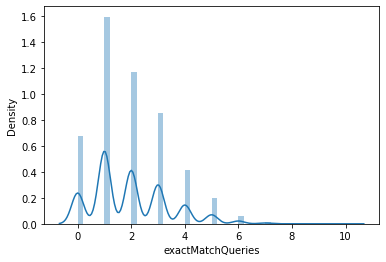

In [46]:
import seaborn as sns
sns.distplot(df_match['exactMatchQueries'])

<AxesSubplot:xlabel='orcasQueriesWithoutExactMatch', ylabel='Density'>

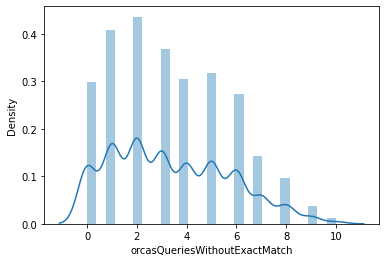

In [48]:
sns.distplot(df_match['orcasQueriesWithoutExactMatch'].apply(lambda i: len(i)))

In [49]:
sum(df_match['orcasQueriesWithoutExactMatch'].apply(lambda i: len(i)))

33646

In [50]:
sum(df_match['orcasQueries'].apply(lambda i: len(i)))

53041

In [51]:
(53041-33646)/53041

0.3656605267623159

# Exact containment orcas queries

In [1]:
!cat /mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-probst/ms-marco-docs/msmarco-docs.tsv|wc -l

3213835


In [4]:
from tqdm import tqdm
doc_to_url = {}

with open('/mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-probst/ms-marco-docs/msmarco-docs.tsv') as f:
    for l in tqdm(f):
        l = l.split('\t')
        doc_to_url[l[0]] = l[1]

3213835it [01:11, 44656.48it/s]


In [5]:
len(doc_to_url)

3213835

In [7]:
import pandas as pd
df_orcas = pd.read_csv('/mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-probst/ms-marco-docs/orcas.tsv.gz', sep='\t', names=['Q_ID', 'Query', 'D_ID', 'D_URL'])

In [8]:
df_orcas

,Q_ID,Query,D_ID,D_URL
0,9265503,github,D1265400,https://desktop.github.com/
1,9265503,github,D3438005,https://github.com/
2,6832981,youtube,D2923232,https://au.youtube.com/
3,9571352,!,D1238374,https://www.englishclub.com/writing/punctuatio...
4,9571352,!,D889000,http://nationalpunctuationday.com/exclamationp...
...,...,...,...,...
18823548,9364218,ð¤¨ meaning,D325990,https://www.merriam-webster.com/dictionary/mea...
18823549,10717906,ð¤© meaning,D325990,https://www.merriam-webster.com/dictionary/mea...
18823550,10942226,ð¤ª emoji,D74189,http://www.iemoji.com/
18823551,11264972,ð¦,D1165065,https://www.lifewire.com/less-obvious-emoji-me...


In [16]:
df_orcas['is_exact_url_match'] = df_orcas.apply(lambda i: exact_url_match(i['D_URL'], i['Query']), axis=1)

In [18]:
df_orcas.to_json('/mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-probst/ms-marco-docs/orcas-with-exact-url-match-field.tsv', lines=True, orient='records')

In [20]:
!head -5 /mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-probst/ms-marco-docs/orcas-with-exact-url-match-field.tsv

{"Q_ID":9265503,"Query":"github","D_ID":"D1265400","D_URL":"https:\/\/desktop.github.com\/","is_exact_url_match":true}
{"Q_ID":9265503,"Query":"github","D_ID":"D3438005","D_URL":"https:\/\/github.com\/","is_exact_url_match":true}
{"Q_ID":6832981,"Query":"youtube","D_ID":"D2923232","D_URL":"https:\/\/au.youtube.com\/","is_exact_url_match":true}
{"Q_ID":9571352,"Query":"!","D_ID":"D1238374","D_URL":"https:\/\/www.englishclub.com\/writing\/punctuation-slash.htm","is_exact_url_match":false}
{"Q_ID":9571352,"Query":"!","D_ID":"D889000","D_URL":"http:\/\/nationalpunctuationday.com\/exclamationpoint.html","is_exact_url_match":false}


In [24]:
(len(df_orcas[df_orcas['is_exact_url_match'] == True]))/len(df_orcas)

0.21004695553490885

In [25]:
df_orcas[df_orcas['is_exact_url_match'] == True]

,Q_ID,Query,D_ID,D_URL,is_exact_url_match
0,9265503,github,D1265400,https://desktop.github.com/,True
1,9265503,github,D3438005,https://github.com/,True
2,6832981,youtube,D2923232,https://au.youtube.com/,True
245,7953050,in excel,D757335,https://blog.udemy.com/excel-not-equal/,True
246,7953050,in excel,D842129,https://support.office.com/en-us/article/Overv...,True
...,...,...,...,...,...
18805941,9825122,zzzquil,D1419054,https://www.drugs.com/mtm/zzzquil.html,True
18805950,5458619,zzzquil for sleep reviews,D1270756,https://www.consumerhealthdigest.com/sleep-aid...,True
18805960,5357757,zzzquil review,D1270756,https://www.consumerhealthdigest.com/sleep-aid...,True
18805961,5357757,zzzquil review,D2120934,http://www.sogoodblog.com/2014/02/17/zzzquil-r...,True


In [26]:
df_orcas[df_orcas['is_exact_url_match'] == False]

,Q_ID,Query,D_ID,D_URL,is_exact_url_match
3,9571352,!,D1238374,https://www.englishclub.com/writing/punctuatio...,False
4,9571352,!,D889000,http://nationalpunctuationday.com/exclamationp...,False
5,9571352,!,D291024,https://en.wikipedia.org/wiki/Exclamation_mark,False
6,9571352,!,D1240274,http://grammar.ccc.commnet.edu/grammar/marks/e...,False
7,9571352,!,D1341457,https://en.wikipedia.org/wiki/Inverted_questio...,False
...,...,...,...,...,...
18823548,9364218,ð¤¨ meaning,D325990,https://www.merriam-webster.com/dictionary/mea...,False
18823549,10717906,ð¤© meaning,D325990,https://www.merriam-webster.com/dictionary/mea...,False
18823550,10942226,ð¤ª emoji,D74189,http://www.iemoji.com/,False
18823551,11264972,ð¦,D1165065,https://www.lifewire.com/less-obvious-emoji-me...,False
